In [2]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
from pricing.black_scholes import black_scholes
from pricing.monte_carlo import simulate_paths_gbm, monte_carlo_option_price, compare_with_black_scholes

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## 1. Define Option Parameters

We'll use standard option pricing parameters for our comparison.

In [3]:
# Option parameters
S0 = 100        # Current stock price
K = 100         # Strike price (ATM)
T = 1.0         # 1 year to expiration
r = 0.05        # 5% risk-free rate
sigma = 0.2     # 20% volatility

print(f"Option Parameters:")
print(f"  Spot Price (S0):     ${S0}")
print(f"  Strike Price (K):    ${K}")
print(f"  Time to Expiration:  {T} year(s)")
print(f"  Risk-free Rate:      {r*100}%")
print(f"  Volatility:          {sigma*100}%")

Option Parameters:
  Spot Price (S0):     $100
  Strike Price (K):    $100
  Time to Expiration:  1.0 year(s)
  Risk-free Rate:      5.0%
  Volatility:          20.0%


## 2. Visualize Monte Carlo Stock Price Paths

Let's simulate multiple stock price paths and visualize them. Each path represents one possible future trajectory of the stock price under geometric Brownian motion.

In [4]:
# Simulate stock price paths
num_paths = 1000
num_steps = 252  # Daily steps over 1 year

paths = simulate_paths_gbm(S0=S0, r=r, sigma=sigma, T=T, 
                           num_steps=num_steps, num_paths=num_paths, seed=42)

print(f"Simulated {num_paths} stock price paths")
print(f"Shape: {paths.shape} (paths, time steps)")
print(f"\nFinal stock prices (at maturity):")
final_prices = paths[:, -1]
print(f"  Min:    ${final_prices.min():.2f}")
print(f"  Mean:   ${final_prices.mean():.2f}")
print(f"  Median: ${np.median(final_prices):.2f}")
print(f"  Max:    ${final_prices.max():.2f}")
print(f"  Std:    ${final_prices.std():.2f}")

Simulated 1000 stock price paths
Shape: (1000, 253) (paths, time steps)

Final stock prices (at maturity):
  Min:    $54.16
  Mean:   $105.09
  Median: $103.87
  Max:    $179.39
  Std:    $20.77


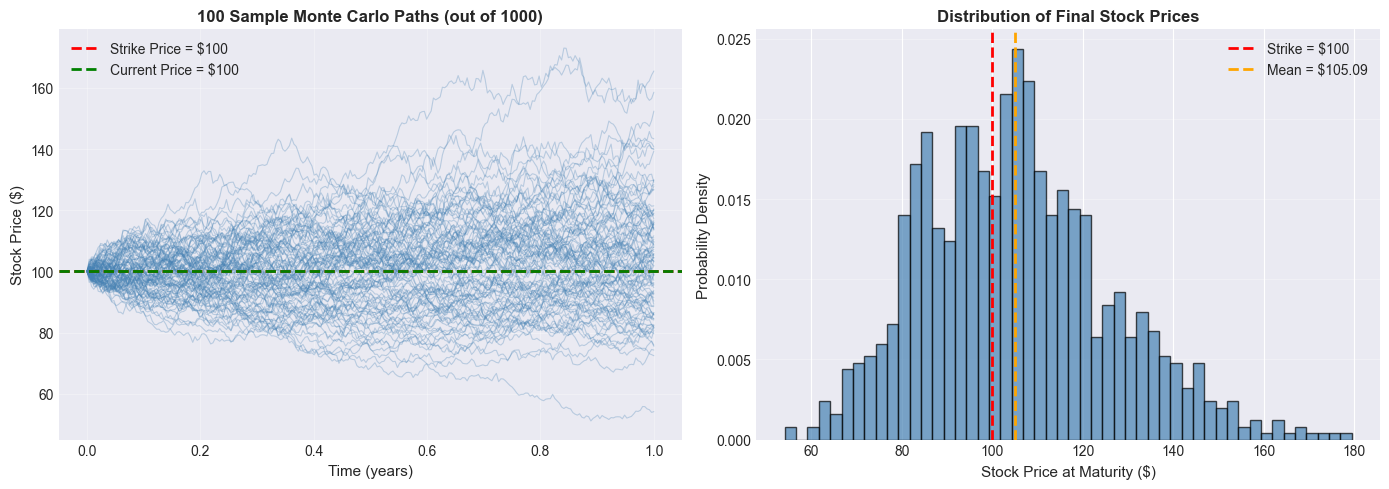


Visualization shows:
  - Left: 100 simulated paths show range of possible outcomes
  - Right: Final price distribution is log-normal (GBM property)


In [5]:
# Visualize stock price paths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sample of 100 paths
ax = axes[0]
time_steps = np.linspace(0, T, num_steps + 1)
sample_paths = paths[:100, :]
ax.plot(time_steps, sample_paths.T, alpha=0.3, linewidth=0.8, color='steelblue')
ax.axhline(y=K, color='red', linestyle='--', linewidth=2, label=f'Strike Price = ${K}')
ax.axhline(y=S0, color='green', linestyle='--', linewidth=2, label=f'Current Price = ${S0}')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Stock Price ($)', fontsize=11)
ax.set_title(f'100 Sample Monte Carlo Paths (out of {num_paths})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Distribution of final prices
ax = axes[1]
ax.hist(final_prices, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(x=K, color='red', linestyle='--', linewidth=2, label=f'Strike = ${K}')
ax.axvline(x=final_prices.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean = ${final_prices.mean():.2f}')
ax.set_xlabel('Stock Price at Maturity ($)', fontsize=11)
ax.set_ylabel('Probability Density', fontsize=11)
ax.set_title('Distribution of Final Stock Prices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nVisualization shows:")
print(f"  - Left: 100 simulated paths show range of possible outcomes")
print(f"  - Right: Final price distribution is log-normal (GBM property)")

## 3. Calculate Call Option Prices: Monte Carlo vs Black-Scholes

Now let's calculate the call option price using both methods and show how the Monte Carlo estimate converges to the analytical BS price.

In [6]:
# Black-Scholes price (analytical)
bs_call_price = black_scholes(S=S0, K=K, T=T, r=r, sigma=sigma, option_type='call')
bs_put_price = black_scholes(S=S0, K=K, T=T, r=r, sigma=sigma, option_type='put')

print("=" * 60)
print("BLACK-SCHOLES ANALYTICAL PRICES")
print("=" * 60)
print(f"Call Option Price: ${bs_call_price:.4f}")
print(f"Put Option Price:  ${bs_put_price:.4f}\n")

# Monte Carlo prices
mc_call_price = monte_carlo_option_price(S0=S0, K=K, r=r, sigma=sigma, T=T, 
                                         option_type='call', num_paths=num_paths, seed=42)
mc_put_price = monte_carlo_option_price(S0=S0, K=K, r=r, sigma=sigma, T=T, 
                                        option_type='put', num_paths=num_paths, seed=42)

print("=" * 60)
print(f"MONTE CARLO PRICES (with {num_paths} paths)")
print("=" * 60)
print(f"Call Option Price: ${mc_call_price:.4f}")
print(f"Put Option Price:  ${mc_put_price:.4f}\n")

# Calculate errors
call_error = abs(mc_call_price - bs_call_price)
call_rel_error = (call_error / bs_call_price) * 100
put_error = abs(mc_put_price - bs_put_price)
put_rel_error = (put_error / bs_put_price) * 100

print("=" * 60)
print("PRICING ERRORS")
print("=" * 60)
print(f"Call Error: ${call_error:.4f} ({call_rel_error:.2f}%)")
print(f"Put Error:  ${put_error:.4f} ({put_rel_error:.2f}%)")

BLACK-SCHOLES ANALYTICAL PRICES
Call Option Price: $10.4506
Put Option Price:  $5.5735

MONTE CARLO PRICES (with 1000 paths)
Call Option Price: $10.3612
Put Option Price:  $5.5227

PRICING ERRORS
Call Error: $0.0894 (0.86%)
Put Error:  $0.0508 (0.91%)


## 4. Show How Monte Carlo Calculates Option Price

Let's break down how the Monte Carlo price is calculated step-by-step, showing the payoffs and discounting.

In [7]:
# Step-by-step breakdown of MC calculation
print("=" * 70)
print("MONTE CARLO CALCULATION BREAKDOWN (CALL OPTION)")
print("=" * 70)

# Step 1: Final prices
final_prices = paths[:, -1]
print(f"\n1. Final Stock Prices (at T=1 year):")
print(f"   Min:  ${final_prices.min():.2f}")
print(f"   Mean: ${final_prices.mean():.2f}")
print(f"   Max:  ${final_prices.max():.2f}")

# Step 2: Payoffs
call_payoffs = np.maximum(final_prices - K, 0)
put_payoffs = np.maximum(K - final_prices, 0)

print(f"\n2. Option Payoffs at Maturity:")
print(f"   Call Payoff = max(S_T - K, 0)")
print(f"   Put Payoff = max(K - S_T, 0)")
print(f"\n   Call Payoffs - Min: ${call_payoffs.min():.2f}, Mean: ${call_payoffs.mean():.2f}, Max: ${call_payoffs.max():.2f}")
print(f"   Put Payoffs  - Min: ${put_payoffs.min():.2f}, Mean: ${put_payoffs.mean():.2f}, Max: ${put_payoffs.max():.2f}")

# Step 3: Average payoff
avg_call_payoff = np.mean(call_payoffs)
avg_put_payoff = np.mean(put_payoffs)

print(f"\n3. Expected (Average) Payoff:")
print(f"   E[Call Payoff] = ${avg_call_payoff:.4f}")
print(f"   E[Put Payoff]  = ${avg_put_payoff:.4f}")

# Step 4: Discount
discount_factor = np.exp(-r * T)
print(f"\n4. Discount Factor = exp(-r*T) = exp(-{r}*{T}) = {discount_factor:.4f}")

# Step 5: Option price
mc_call_final = discount_factor * avg_call_payoff
mc_put_final = discount_factor * avg_put_payoff

print(f"\n5. Option Price = Discount Factor × E[Payoff]:")
print(f"   MC Call Price = {discount_factor:.4f} × ${avg_call_payoff:.4f} = ${mc_call_final:.4f}")
print(f"   MC Put Price  = {discount_factor:.4f} × ${avg_put_payoff:.4f} = ${mc_put_final:.4f}")

MONTE CARLO CALCULATION BREAKDOWN (CALL OPTION)

1. Final Stock Prices (at T=1 year):
   Min:  $54.16
   Mean: $105.09
   Max:  $179.39

2. Option Payoffs at Maturity:
   Call Payoff = max(S_T - K, 0)
   Put Payoff = max(K - S_T, 0)

   Call Payoffs - Min: $0.00, Mean: $10.89, Max: $79.39
   Put Payoffs  - Min: $0.00, Mean: $5.81, Max: $45.84

3. Expected (Average) Payoff:
   E[Call Payoff] = $10.8925
   E[Put Payoff]  = $5.8058

4. Discount Factor = exp(-r*T) = exp(-0.05*1.0) = 0.9512

5. Option Price = Discount Factor × E[Payoff]:
   MC Call Price = 0.9512 × $10.8925 = $10.3612
   MC Put Price  = 0.9512 × $5.8058 = $5.5227


## 5. Analyze Convergence of Monte Carlo Estimate

As we increase the number of simulation paths, the Monte Carlo estimate should converge to the Black-Scholes price. Let's demonstrate this convergence.

In [8]:
# Test convergence with different numbers of paths
path_counts = [100, 500, 1000, 5000, 10000, 50000]
mc_prices = []
mc_errors = []

print("Testing Convergence of Monte Carlo Estimate...")
print("-" * 60)
print(f"{'Num Paths':<12} {'MC Price':<12} {'BS Price':<12} {'Error $':<12} {'Error %':<10}")
print("-" * 60)

for num_p in path_counts:
    mc_price = monte_carlo_option_price(S0=S0, K=K, r=r, sigma=sigma, T=T,
                                        option_type='call', num_paths=num_p, seed=42)
    error = abs(mc_price - bs_call_price)
    error_pct = (error / bs_call_price) * 100
    
    mc_prices.append(mc_price)
    mc_errors.append(error)
    
    print(f"{num_p:<12} ${mc_price:<11.4f} ${bs_call_price:<11.4f} ${error:<11.4f} {error_pct:<9.2f}%")

print("-" * 60)
print(f"\nKey Insight: Error decreases as O(1/√n)")
print(f"Each 10x increase in paths → ~3.16x decrease in error")

Testing Convergence of Monte Carlo Estimate...
------------------------------------------------------------
Num Paths    MC Price     BS Price     Error $      Error %   
------------------------------------------------------------
100          $9.8984      $10.4506     $0.5522      5.28     %
500          $10.5781     $10.4506     $0.1275      1.22     %
1000         $10.3612     $10.4506     $0.0894      0.86     %
5000         $10.0595     $10.4506     $0.3911      3.74     %
10000        $10.2211     $10.4506     $0.2295      2.20     %
50000        $10.3485     $10.4506     $0.1021      0.98     %
------------------------------------------------------------

Key Insight: Error decreases as O(1/√n)
Each 10x increase in paths → ~3.16x decrease in error


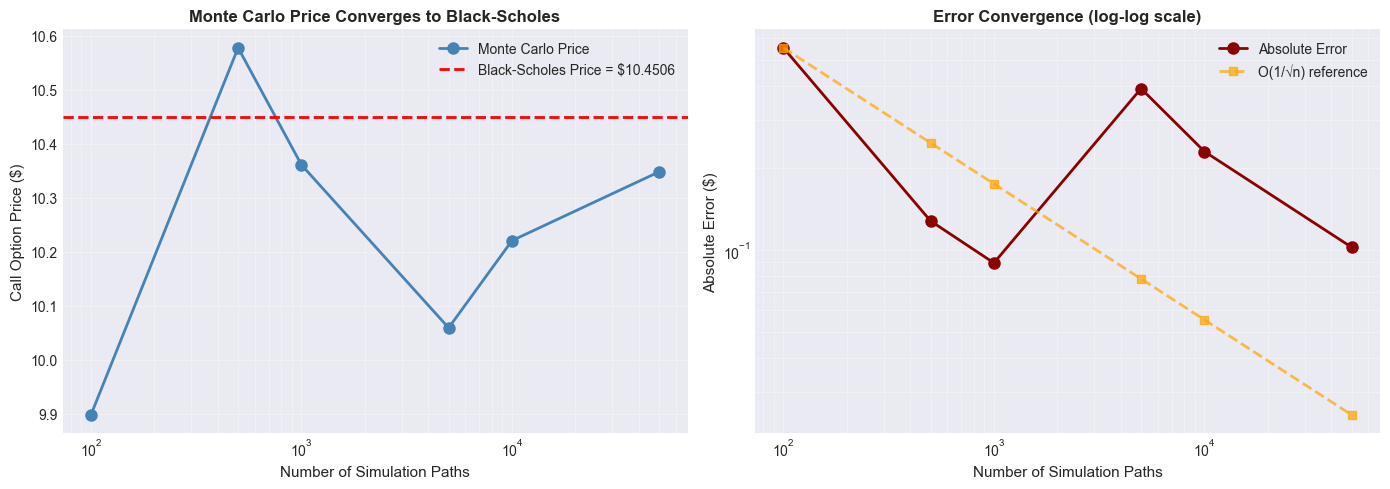


Visualization shows:
  - Left: MC price converges to BS price as paths increase
  - Right: Error decreases following O(1/√n) theoretical rate


In [9]:
# Visualize convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MC price convergence to BS price
ax = axes[0]
ax.plot(path_counts, mc_prices, 'o-', linewidth=2, markersize=8, label='Monte Carlo Price', color='steelblue')
ax.axhline(y=bs_call_price, color='red', linestyle='--', linewidth=2, label=f'Black-Scholes Price = ${bs_call_price:.4f}')
ax.set_xscale('log')
ax.set_xlabel('Number of Simulation Paths', fontsize=11)
ax.set_ylabel('Call Option Price ($)', fontsize=11)
ax.set_title('Monte Carlo Price Converges to Black-Scholes', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# Plot 2: Absolute error on log scale
ax = axes[1]
ax.loglog(path_counts, mc_errors, 'o-', linewidth=2, markersize=8, label='Absolute Error', color='darkred')

# Add theoretical convergence line O(1/sqrt(n))
theoretical_errors = mc_errors[0] / np.sqrt(np.array(path_counts) / path_counts[0])
ax.loglog(path_counts, theoretical_errors, 's--', linewidth=2, markersize=6, label='O(1/√n) reference', color='orange', alpha=0.7)

ax.set_xlabel('Number of Simulation Paths', fontsize=11)
ax.set_ylabel('Absolute Error ($)', fontsize=11)
ax.set_title('Error Convergence (log-log scale)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nVisualization shows:")
print("  - Left: MC price converges to BS price as paths increase")
print("  - Right: Error decreases following O(1/√n) theoretical rate")

## 6. Summary: When to Use Each Method

| Aspect | Black-Scholes | Monte Carlo |
|--------|-------------|----------|
| **Speed** | Instant (analytic formula) | Slower (requires simulation) |
| **European Options** | ✅ Excellent | ✅ Good (converges slowly) |
| **American Options** | ❌ Cannot handle | ✅ Can handle (LSMC) |
| **Path-dependent Options** | ❌ Cannot handle | ✅ Excellent |
| **Accuracy** | Exact (for assumptions) | Approximate (improves with paths) |
| **Use Case** | Benchmarking, pricing simple options | Complex derivatives, validation |

**Key Takeaway:** Monte Carlo provides a flexible framework for pricing any type of option, while Black-Scholes offers instant analytical solutions for European options. The two methods converge nicely, validating our implementations!